# <center> Options: Call and Put</center>
# $$ \text{by JZ} $$

### Target : interactive visualization of the option values and payoff  
(We compare also the cumulative distribution functions (cdf) : approximation vs  scipy.stats)

$$ \huge Formula $$

$$C\left(S,t\right)  =Se^{-q(T-t)}N(d_{1})-Ke^{-r(T-t)}N(d_{2})$$
and
$$ P\left(S,t\right)  =-Se^{-q(T-t)}N(-d_{1})+Ke^{-r(T-t)}N(-d_{2})$$

where

$$d_{1,2}=\frac{\log(S/K)+(r-q\pm\frac{1}{2}\sigma^{2})(T-t)}{\sigma\sqrt{T-t}%
}\;\text{with}$$

$$d_{2}=d_{1}-\sigma\sqrt{T-t}.$$

with cumulative distribution function for the normal distribution N(0,1)


$$N(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-\frac{1}{2}z~^{2}}dz$$ 

### Imports required modules

In [1]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import *

### functions for pricing 

In [2]:
def cdf_approx(X):
    '''
     Approximation of the cumulative distribution function for the normal distribuition
    '''
    (a1,a2,a3,a4,a5) = (0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    x=abs(X)
    k=1/(1+0.2316419*x)
    n=(1/math.sqrt(2*math.pi))*math.exp(-0.5*x**2)
    N=1.0-n*(a1*k+a2*k**2+a3*math.pow(k,3)+a4*math.pow(k,4)+a5*math.pow(k,5))
    if X<0:
        N=1.0-N
    return N
#_______________________________________________________________________________________
def payoff_call(S,K):
    return np.maximum(S-K,0.0)

def payoff_put(S,K):
    return np.maximum(K-S,0.0)
#_______________________________________________________________________________________

def _price_option(stock,strike,r,vol,div,time_to_maturity,is_call,cdf=None):
    '''
    function to price a call or a put.
    
    stock: float stock price 
    strike: float strike price 
    r : risk free rate 
    vol: volatility (example: 20% = 0.2) 
    div: Dividend yield (example: 20% = 0.2)
    time_to_maturity: T-t 
    is_call : bool, if True is a call option otherwise it's a put
    cdf: callable/function to use for the cdf ( approx or real)  
    '''
    if cdf is None : 
        cdf = cdf_approx
    moneyness = np.log(stock/strike)
    shift=r-div+0.5*np.power(vol,2)
    d1=(moneyness+shift*time_to_maturity)/(vol*np.sqrt(time_to_maturity))
    d2=d1-vol*np.sqrt(time_to_maturity)
    cdf = np.vectorize(cdf)
    if is_call: 
        call=stock*np.exp(-div*time_to_maturity)*cdf(d1)-np.exp(-r*time_to_maturity)*strike*cdf(d2)
        return call
    else:
        put=-stock*np.exp(-div*time_to_maturity)*cdf(-d1)+np.exp(-r*time_to_maturity)*strike*cdf(-d2)
        return put     

def call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None):
    return _price_option(stock,strike,r,vol,div,time_to_maturity,is_call=True,cdf=cdf)

def put_option(stock,strike,r,vol,div,time_to_maturity,cdf=None):
     return _price_option(stock,strike,r,vol,div,time_to_maturity,is_call=False,cdf=cdf)


### Test functions

In [3]:
# Uncomment the code below if you just want to try to price a call/put 
# stock=float(100)
# strike=float(50)
# r=float(0.03)
# div=float(0.0)
# vol=float(0.5)
# T=float(1.0)
# t=float(0.0)
# time_to_maturity=T-t
# print(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
# print(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))

### Graph playground

In [4]:
def run_interactive_graph():
    '''
     function to launch the interactive graph to plot the call and/or put option with sliders parameters
    '''

    # Set size and 
    fig = plt.figure(figsize=(7, 4))
    fig.suptitle('Option(s) Value : maturity 1Y',ha="center",fontsize=14)
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(top=0.8) 
    ax.set_xlabel("Strike")
    ax.set_ylabel(r"Option Value")

    
    # initialise the state 
    stock = np.linspace(50,150,num=50)
    #print(f"Nb points on the curve = nb stocks ={len(stock)}")
    strike=100.0
    r=0.03        # risk free rate = 3% 
    div=0.0       # divident yield rate = 0% 
    vol=0.2       # volatility = 20%

    # Fix for the simulation 
    time_to_maturity=1 # we fix this parameter to 1Y 

    # Create the different lines 
    line_call_approx, = ax.plot(stock, call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None),label="call_approx")
    line_put_approx, = ax.plot(stock, put_option(stock,strike,r,vol,div,time_to_maturity,cdf=None),label="put_approx",visible=False)
    line_call, = ax.plot(stock, call_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf),label="call")
    line_put, = ax.plot(stock, put_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf),label="put",visible=False)
    line_payoff_call, = ax.plot(stock, payoff_call(stock,strike),label="call_payoff",visible=False)
    line_payoff_put, = ax.plot(stock, payoff_put(stock,strike),label="put_payoff",visible=False)

    # Show the strike as vertical red line 
    plt.axvline(x=strike,color='Red')

    # function used to update the graph interactively 
    # Each input is a sliders. More info here : https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#container-layout-widgets
    def update(show_payoff = False,
               show_type=widgets.Dropdown(options=['call', 'put', 'both'],value='call'),
               show_cdf=widgets.Dropdown(options=['approx', 'exact', 'both'],value='exact'),
               strike = widgets.IntSlider(min=50, max=150, step=10, value=100),
               vol=widgets.FloatSlider(min=0.0000001, max=1.0, step=0.01, value=0.2,description="Volatility:",readout_format="0.0%"),
               rate_rate = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.03,description="Rate:",readout_format="0.0%"),
               divident_yield = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0,description="Dividend:",readout_format="0.0%")
              ):

        # Call the right function(s) for pricing 
        # and set the visibility of the different lines depending of the inputs
        r = rate_rate
        div= divident_yield
        if show_type=="call":
            line_payoff_call.set_visible(show_payoff)
            line_payoff_put.set_visible(False)
            
            if show_cdf=="approx":
                line_call_approx.set_visible(True)
                line_put_approx.set_visible(False)
                line_call.set_visible(False)
                line_put.set_visible(False)
                
                line_call_approx.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                line_call_approx.set_color("darkblue")
                
            elif show_cdf=="exact":
                line_call.set_visible(True)
                line_call_approx.set_visible(False)
                line_put_approx.set_visible(False)
                line_put.set_visible(False)
                
                line_call.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
                line_call.set_color("cyan") 
                
            else:
                line_call_approx.set_visible(True)
                line_call.set_visible(True)
                line_put_approx.set_visible(False)
                line_put.set_visible(False)
                
                line_call.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
                line_call_approx.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                line_call.set_color("cyan")
                line_call_approx.set_color("darkblue")
        
        elif show_type=="put":
            line_payoff_call.set_visible(False)
            line_payoff_put.set_visible(show_payoff)
            if show_cdf=="approx":
                line_put_approx.set_visible(True)
                line_call.set_visible(False)
                line_put.set_visible(False)
                line_call_approx.set_visible(False)
                line_put_approx.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                line_put_approx.set_color("darkgrey")
                
            elif show_cdf=="exact":
                line_put.set_visible(True)
                line_call.set_visible(False)
                line_call_approx.set_visible(False)
                line_put_approx.set_visible(False)
                
                line_put.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
                line_put.set_color("lightgrey")
            else:
                line_put.set_visible(True)
                line_call.set_visible(False)
                line_call_approx.set_visible(False)
                line_put_approx.set_visible(True)
                
                line_put_approx.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                line_put.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
    
                line_put.set_color("lightgrey")
                line_put_approx.set_color("darkgrey")
        else:
            line_payoff_call.set_visible(show_payoff)
            line_payoff_put.set_visible(show_payoff)
            if show_cdf=="approx":
                line_call.set_visible(False)
                line_put.set_visible(False)
                line_call_approx.set_visible(True)
                line_put_approx.set_visible(True)
                
                line_call_approx.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                line_put_approx.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
    
                line_call_approx.set_color("darkblue")
                line_put_approx.set_color("darkgrey")
                
            elif show_cdf=="exact":
                line_call.set_visible(True)
                line_put.set_visible(True)
                line_call_approx.set_visible(False)
                line_put_approx.set_visible(False)
                
                line_call.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
                line_put.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
    
                line_put.set_color("lightgrey")
                line_call.set_color("cyan")
            else:
                line_call.set_visible(True)
                line_put.set_visible(True)
                line_call_approx.set_visible(True)
                line_put_approx.set_visible(True)
                
                line_call.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
                line_put.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=norm.cdf))
                line_call_approx.set_ydata(call_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                line_put_approx.set_ydata(put_option(stock,strike,r,vol,div,time_to_maturity,cdf=None))
                
                line_call.set_color("cyan")
                line_call_approx.set_color("darkblue")
                line_put.set_color("lightgrey")
                line_put_approx.set_color("darkgrey")

        # add the legends 
        ax.legend(bbox_to_anchor=(0., 1., 1., .102), 
               loc='lower left',
               ncols=4, mode="expand", borderaxespad=0.)
        
        # remove the previous stike line 
        plt.gca().lines[-1].remove()

        # add the new strike line 
        plt.axvline(x=strike,color='Red')

        # show 
        fig.canvas.draw_idle()
        
    interact(update);

interactive(children=(Checkbox(value=False, description='show_payoff'), Dropdown(description='show_type', opti…

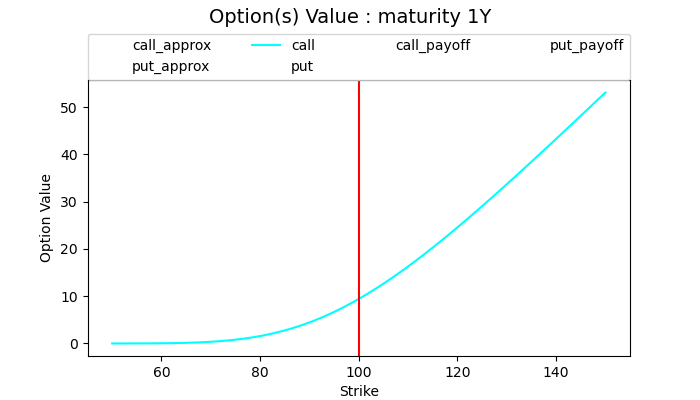

In [5]:
run_interactive_graph()
# You really have to zoom in to see the difference between the "exact" and the "approximation" of the cdf

### Options Strategies

In [6]:
#________________________________________________________________________________________________________________________
class Option:
    def __init__(self,stock,strike,rate,vol,div,time_to_maturity,option_type):
        self.stock= stock
        self.strike = strike
        self.rate= rate
        self.vol = vol 
        self.div = div 
        self.time_to_maturity = time_to_maturity
        self.option_type = option_type

    def __repr__(self):
        return f"Option(stock={self.stock},strike={self.strike},rate = {self.rate},vol={self.vol}, div={self.div},maturity={self.time_to_maturity},option_type={self.option_type}"
    
    def price(self,spot):
        if self.option_type=="CALL":
            return call_option(spot,self.strike,self.rate,self.vol,self.div,self.time_to_maturity,cdf=None)
        if self.option_type=="PUT":
            return put_option(spot,self.strike,self.rate,self.vol,self.div,self.time_to_maturity,cdf=None)    
#________________________________________________________________________________________________________________________
class CallOption(Option):
    def __init__(self,stock,strike,rate,vol,div,time_to_maturity):
           super().__init__( stock,strike,rate,vol,div,time_to_maturity,option_type="CALL")
        
class PutOption(Option):
    def __init__(self,stock,strike,rate,vol,div,time_to_maturity):
           super().__init__( stock,strike,rate,vol,div,time_to_maturity,option_type="PUT")   
#________________________________________________________________________________________________________________________
class Position:
    def __init__(self,option,quantity):
        self.option= option 
        self.quantity= quantity

    def __repr__(self):
        return f"Position(option={self.option},quantity={self.quantity}"
        
    def payoff(self,spot):
        val = None 
        if self.option.option_type=="CALL":
                val=  float(self.quantity)*max(spot-self.option.strike,0.0)
        elif self.option.option_type=="PUT":
                val=  float(self.quantity)*max(self.option.strike-spot,0.0)
        return val
        
    def price(self,spot):
        return float(self.quantity)*self.option.price(spot)
#________________________________________________________________________________________________________________________
class Portfolio:
    def __init__(self,positions,name=''):
        self.positions = positions
        self.name=name
        
    def payoff(self,spot):
          value = 0.0
          for pos in self.positions:
              value += pos.payoff(spot)
          return value
    
    def price(self,spot):
        res = 0.0  
        for pos in self.positions:
            res+=pos.price(spot)
        return res

    def __repr__(self):
        res = self.name+":"  
        for pos in self.positions:
            res+=str(pos)
        return res
    
    def get_strategy_text(self):
        strategy = []
        for pos in self.positions:
            if pos.quantity!= 0:
                msg = "buy " if pos.quantity > 0 else "sell "
                msg += f"{int(abs(pos.quantity))}, {pos.option.strike} {pos.option.option_type} "
                strategy.append(msg)
        return strategy

In [10]:
# # Simple test
# call_1 = CallOption(stock=100,strike=100,rate=0.03,vol=0.2,div=0.0,time_to_maturity=1)
# put_1  = PutOption (stock=100,strike=100,rate=0.03,vol=0.2,div=0.0,time_to_maturity=1)
# pos_1 = Position(call_1,1) 
# pos_2 = Position(put_1,-1)
# ptf= Portfolio([pos_1,pos_2])
# ptf.payoff(10.0)



In [12]:
def run_interactive_payoff():
    '''
     Show payoff
    '''
    # Set size and 
    fig = plt.figure(figsize=(7, 4))
    fig.suptitle('Payoff Strategy :',ha="center",fontsize=14)
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(top=0.8) 
    ax.set_xlabel("Spot")
    ax.set_ylabel(r"Payoff")

    plt.axhline(y=0.0, color='r', linestyle='-')
    
    # initialise the state 
    stock = np.linspace(50,150,num=300)
    #print(f"Nb points on the curve = nb stocks ={len(stock)}")
    strike=100.0
    r=0.03        # risk free rate = 3% 
    div=0.0       # divident yield rate = 0% 
    vol=0.2       # volatility = 20%

    # Fix for the simulation 
    time_to_maturity=1 # we fix this parameter to 1Y 

    # Create the different lines 
    #line_payoff, = ax.plot(stock, 0.0,label="payoff")
    #line_ptf_value, = ax.plot(stock, 0.0,label="value")

    default_ptf_values = '1,C,100.0\n-1,P,100.0'
    
    # Show the strike as vertical red line 
    #plt.axvline(x=strike,color='Red')

    # function used to update the graph interactively 
    # Each input is a sliders. More info here : https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#container-layout-widgets
    def update(
               strategy = widgets.SelectMultiple(
                                            options=['No_Strategy', 'Straddle', 'Strangle',"Butterfly","Condor"],
                                            value=['No_Strategy'],
                                            description='strategy',
                                            disabled=False
                                        ),
               vol=widgets.FloatSlider(min=0.0000001, max=1.0, step=0.01, value=0.2,description="Volatility:",readout_format="0.0%"),
               rate_rate = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.03,description="Rate:",readout_format="0.0%"),
               divident_yield = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0,description="Dividend:",readout_format="0.0%"),
               portfolio = widgets.Textarea(value=default_ptf_values,
               placeholder='Define your own strategy : <S for short,L for long>,<quantity>,<C for call/P for put>,Strike',
               description='create your own strategy',
                ),
              ):

        def generate_ptf_from_string(portfolio):
            rows = portfolio.split("\n")
            positions = []
            nb_call=0
            nb_put=0
            spot=100.0 # it will move during the pricing
            for row in rows:
                if row :
                    try : 
                        data = row.split(",")
                        quantity = float(data[0].strip().upper()) # Long or Short
                        option_type = data[1].strip().upper() # Call or Put 
                        strike = float(data[2].strip().upper()) # strike 
        
                        #check
                        if option_type not in ["C","P"]:
                            continue
                        
                        option=None
                        if option_type == "C":
                            nb_call+=1
                            option = CallOption(stock=spot,strike=strike,rate=rate_rate,vol=vol,div=divident_yield,time_to_maturity=1)
                        else:
                            nb_put+=1
                            option = PutOption(stock=spot,strike=strike,rate=rate_rate,vol=vol,div=divident_yield,time_to_maturity=1)
        
                        position = Position(option,quantity)
                        positions.append(position)
                    except Exception as ex: 
                        print(f"Error {ex}")
            ptf = Portfolio(positions,name= f"Strategy:#Option={nb_call+nb_put}, #Call={nb_call}, #Put={nb_put}")
            return ptf    

        default_ptf_values=portfolio
        ptf = None 
        portfolio_str = portfolio
        print(f"strategy={strategy}")
        if strategy : 
            strategy_imp = strategy[0]
        else:
            portfolio_str="1,C,100\n -1,P,100"
        if strategy_imp == 'No_Strategy':   
            pass
        elif strategy_imp == 'Straddle':   
            portfolio_str="1,C,100\n 1,P,100"
        
        elif strategy_imp == 'Strangle':   
            portfolio_str="1,P,95\n 1,C,110"
        
        elif strategy_imp == 'Butterfly':   
            portfolio_str="1,C,80\n -2,C,100\n 1,C,120"
            
        elif strategy_imp == 'Condor':   
            portfolio_str="1,C,80\n -1,C,90\n -1,C,110\n 1,C,120"

        print(f"portfolio_str = {portfolio_str}")
        ptf = generate_ptf_from_string(portfolio_str)
        
        strategy_vect = ptf.get_strategy_text()
        strategy_str = '\n     '.join(strategy_vect)
        print("Strategy : ",strategy_imp)
        print("     ",strategy_str)
        #print(f"portfolio=\n{ptf}")
        try : 
            while plt.gca().lines: 
                plt.gca().lines[-1].remove()
        except Exception as ex:
            print(f"Error happen={ex}")
            pass
        print("------")
        plt.axhline(y=0.0, color='r', linestyle='-')
        
        payoff_func = np.vectorize(ptf.payoff)
        ptf_value = np.vectorize(ptf.price)
        
        line_payoff, = ax.plot(stock, payoff_func(stock),label="payoff")
        line_ptf_value, = ax.plot(stock, ptf.price(stock),label="value")
        
        line_payoff.set_color("blue")
        line_ptf_value.set_color("cyan")

        ax.legend(bbox_to_anchor=(0., 1., 1., .102), 
               loc='lower left',
               ncols=2, mode="expand", borderaxespad=0.)
        
        # Show the strike as vertical red line 
        plt.axvline(x=strike,color='Red')
    
        # show 
        fig.canvas.draw_idle()
        
    interact(update);

interactive(children=(SelectMultiple(description='strategy', index=(0,), options=('No_Strategy', 'Straddle', '…

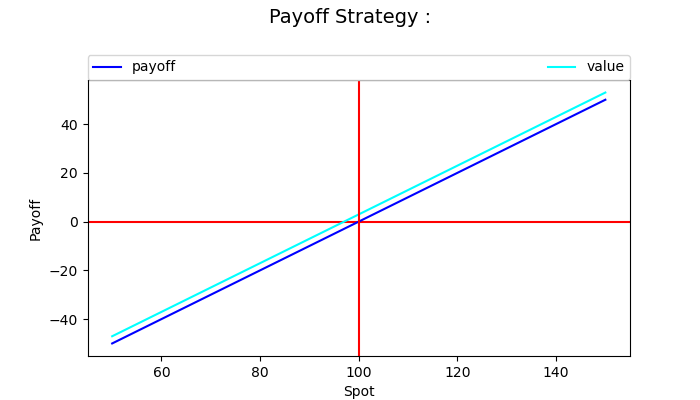

In [13]:
# call_1 = CallOption(stock=100,strike=100,rate=0.03,vol=0.2,div=0.0,time_to_maturity=1)
# put_1  = PutOption (stock=100,strike=100,rate=0.03,vol=0.2,div=0.0,time_to_maturity=1)
# pos_1 = Position(call_1,1,is_long=True) 
# pos_2 = Position(put_1,1,is_long=True)
# ptf= Portfolio([pos_1,pos_2])

run_interactive_payoff()